In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import ffmpeg
from pprint import pprint
import whisper
import torch
from torch.distributions import Categorical
import numpy as np
from whisper.tokenizer import get_tokenizer
from whisper import audio

In [7]:
# fn = "/tmp/perkins.avi [uS78f4WUbXs].webm" # https://www.youtube.com/watch?v=uS78f4WUbXs
fn = "/tmp/Phasmophobia： No Evidence [QoDTqAwskPU].webm" # https://www.youtube.com/watch?v=QoDTqAwskPU
# fn = "/tmp/output.wav"
# fn = "/tmp/separated/htdemucs/output/vocals.wav"
data, _ = ffmpeg.input(fn).output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='16k').run(quiet=True, input='')
data = np.frombuffer(data, np.int16).astype(np.float32) / 32768.0
model = whisper.load_model("tiny")
language = 'en'
tokenizer = get_tokenizer(model.is_multilingual, language=language)

In [8]:
@torch.no_grad()
def transcribe(model, data, **kwargs):

    def _transcribe(features):
        kv_cache, hooks = model.install_kv_cache_hooks()
        tokens = torch.tensor(tokenizer.sot_sequence).repeat(features.shape[0], 1)
        try:
            while not (tokens[:, -1] == tokenizer.eot).all() and tokens.shape[-1] < 250:
                logits = model.decoder(next_tokens, audio_features, kv_cache=kv_cache)[:, -1:, ]
                logitsc = torch.concat([logitsc, logits[:, :, :tokenizer.timestamp_begin-1].detach()], dim=-2)
                # logits[:, :, tokenizer.timestamp_begin+1: tokenizer.timestamp_begin + int(29 // 0.02)] = -np.inf
                next_tokens = Categorical(logits=logits/0.2).sample()
                # next_tokens = logits.argmax(-1)
                next_tokens[tokens[:, -1] == tokenizer.eot] = tokenizer.eot
                tokens = torch.concat([tokens, next_tokens], dim=-1)
        except Exception as e:
            print(e)
        finally:
            for h in hooks: h.remove()
            kv_cache.clear()

        pass
        
    language = kwargs['language']
    tokenizer = get_tokenizer(model.is_multilingual, language=kwargs['language'] if 'language' in kwargs else 'ja')
    batches, beams = 2, 1
    overlap = 5
    left = 30 - overlap

    for i in range(0, data.shape[0], left * 16000 * batches):
        x = data[i:i+left * 16000 * batches + overlap * 16000]
        mel = audio.log_mel_spectrogram(x)
        mels = []
        for k in range(batches):
            chunk = mel[:, k * left*100: k * left*100 + 3000]
            if chunk.shape[-1] == 0: break
            if chunk.shape[-1] < 3000: chunk = audio.pad_or_trim(chunk, audio.N_FRAMES)
            mels.append(chunk.unsqueeze(0))
        mels = torch.concat(mels, dim=0)

        initial = [*tokenizer.sot_sequence]
        tokens = torch.tensor(initial).repeat(mels.shape[0]*beams, 1)
        audio_features = model.encoder(mels).repeat_interleave(beams, dim=0)
        print(tokens.shape)
        next_tokens = tokens
        logitsc = torch.tensor([])
        kv_cache, hooks = model.install_kv_cache_hooks()
        try:
            while not (tokens[:, -1] == tokenizer.eot).all() and tokens.shape[-1] < 250:
                logits = model.decoder(next_tokens, audio_features, kv_cache=kv_cache)[:, -1:, ]
                logitsc = torch.concat([logitsc, logits[:, :, :tokenizer.timestamp_begin-1].detach()], dim=-2)
                # logits[:, :, tokenizer.timestamp_begin+1: tokenizer.timestamp_begin + int(29 // 0.02)] = -np.inf
                next_tokens = Categorical(logits=logits/0.2).sample()
                # next_tokens = logits.argmax(-1)
                next_tokens[tokens[:, -1] == tokenizer.eot] = tokenizer.eot
                tokens = torch.concat([tokens, next_tokens], dim=-1)
        except Exception as e:
            print(e)
        finally:
            for h in hooks: h.remove()
            kv_cache.clear()
            
        for t in tokens.tolist():
            print(tokenizer.decode_with_timestamps(t))
            
        print(tokens.shape, logitsc.shape)
        if (i//(left * 16000 * batches)) >= 1: # HACK for testing
            logitsc, logitscs = logitsc[:-1].softmax(-1), logitsc[1:].log_softmax(-1)
            sm = torch.zeros((batches-1, tokens.shape[-1]-len(initial), tokens.shape[-1]-len(initial)))
            # sm = (logitsc * logitscs).sum(-1) # The dream
            # for k in range(batches-1):
            for i in range(tokens.shape[-1]-len(initial)):
                for j in range(tokens.shape[-1]-len(initial)):
                    sm[..., i, j] = -1/(logitsc[:, i] * logitscs[:, j]).sum(-1)
            return tokens.detach().numpy(), sm.log().detach().numpy()

torch.Size([2, 3])
<|startoftranscript|><|en|><|transcribe|><|0.00|> Boy, do I love lights, which is?<|1.94|><|1.94|> Love turning them on and off. So much fun.<|4.34|><|4.34|> I love turning on lights next to my large collection of throwable objects and also empty notebooks.<|10.34|><|10.34|> It was sure wood suck if someone named Carol Thomas showed up to ruin all my fun. Carol Thomas. Carol Thomas. Carol Thomas.<|17.76|><|17.76|> Hey, I've been here for like half an hour. Can we please just call this a shade 1995?<|21.78|><|21.78|> We need at least one piece of evidence.<|23.60|><|23.60|> I do we though, I feel like the evidence is pretty conclusive.<|26.54|><|26.54|> Let's go through the checklist.<|27.88|><|27.88|> I've already done the checklist.<|29.28|><|29.28|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

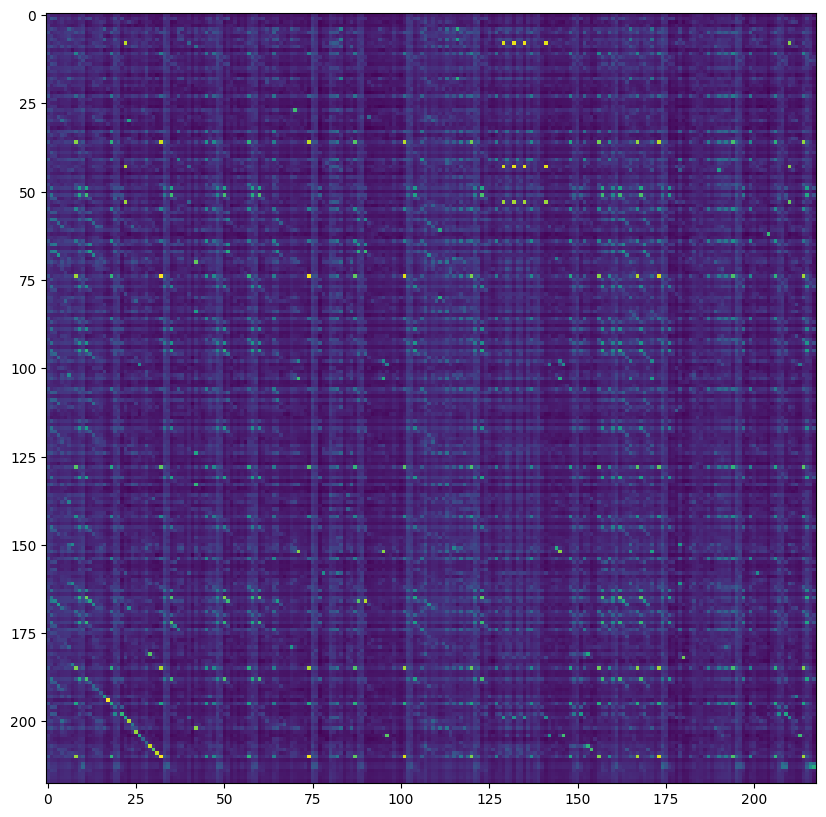

In [9]:
import gc
tokens, sm = transcribe(model, data, language=language)
gc.collect()
tokens = tokens[:, len(tokenizer.sot_sequence)+1:]
# eot0 = len(tokens[0]) if tokenizer.eot not in tokens[0].tolist() else tokens[0].tolist().index(tokenizer.eot)
# eot1 = len(tokens[1]) if tokenizer.eot not in tokens[1].tolist() else tokens[1].tolist().index(tokenizer.eot)

# Will this work for batches > 2? probably not
# Long chains of end tokens match very similarily to each other
# sm = sm[:, 1:eot0, 1:eot1]
sm = sm
print(tokens[0])
print(tokens[1])
plt.figure(figsize=(10, 10))
plt.imshow(sm[-1])

-1.5039689540863037 1.0 41 0
209 213
(-388.241556705907, 215.0)
[-388.24155671 -387.44641702 -387.31478077 ...   -1.54871523   -1.53429031
   -1.50396895]


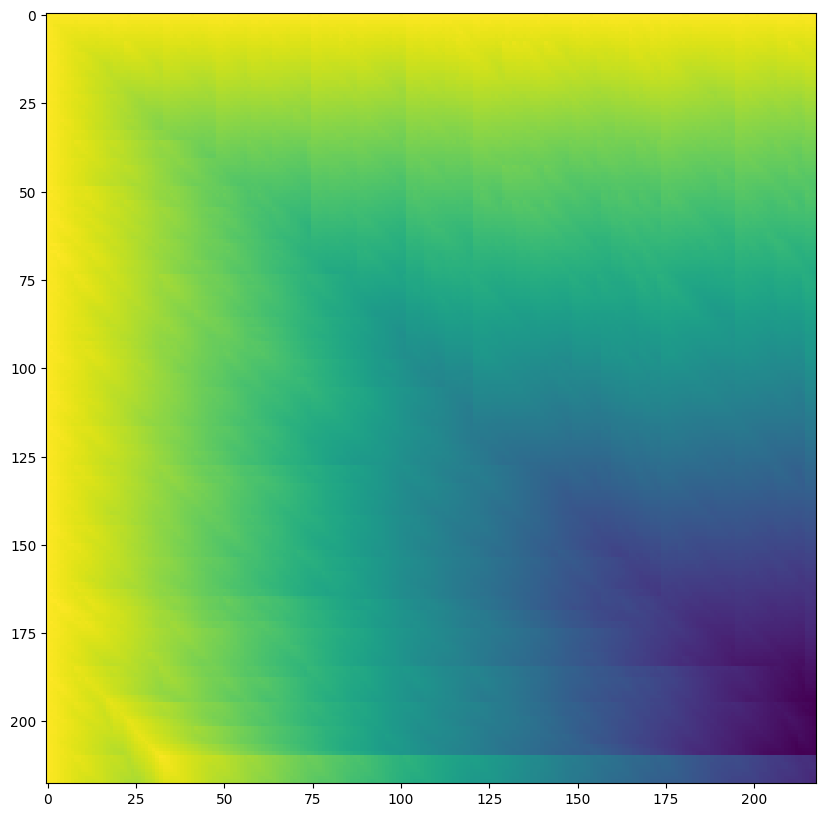

In [20]:
# import math
memo = {}
s = [(-np.inf, 1, 0, 0)]
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        z = [memo.get(d, (0, 0)) for d in [(i-1, j), (i, j-1), (i-1, j-1)]]
        scores, lens = np.array(list(zip(*z)))
        ns = scores + sm[0, i, j]
        # f = ((ns)/(lens+1)).argmax()
        f = ns.argmax()
        memo[i, j] = (ns[f], lens[f]+1)#(1 if f == 2 else 0))
        sn = memo[i, j][0]/memo[i, j][1]# * math.log(-memo[i, j][0]*memo[i, j][1])
        sp = s[-1][0]/s[-1][1]# * math.log(-s[-1][0]*(s[-1][1]))
        # if sn > sp:
        if memo[i, j][0] > s[-1][0]:
        # if memo[i, j][0]/memo[i, j][1] > s[-1][0]/(s[-1][1]):
            s.append((memo[i, j][0], memo[i, j][1], i, j))
            fm, fl, fmi, fmj = memo[i, j][0], memo[i, j][1], i, j

# pprint(s)
fm, fl, fmi, fmj = s[-1]
print(fm, fl, fmi, fmj)
scores = [[0 for j in range(sm.shape[-1])] for i in range(sm.shape[-2])]
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        scores[i][j] = memo[i, j][0]#/memo[i, j][1]# * math.log(-memo[i, j][0]*memo[i, j][1])
f = np.array(scores).reshape(-1)
# print(f[-2])
s = f.argsort()
x = s % sm.shape[-1]
y = s // sm.shape[-1]
idx = 0
print(y[idx], x[idx])
print(memo[y[idx], x[idx]])
fm, fl = memo[y[idx], x[idx]]
fmi, fmj = y[idx], x[idx]
print(f[f.argsort()])
plt.figure(figsize=(10, 10))
plt.imshow(scores)

In [27]:
dirs = [(-1, 0), (0, -1), (-1, -1)]
ci, cj = fmi, fmj
l = memo[ci, cj][1]
trace = []
z = [i for i in range(len(dirs))]
while ci > 0 and cj > 0:# and memo[ci, cj][0] > 0:
    trace.append((ci, cj))
    d = sorted(z, key=lambda x: memo.get((ci+dirs[x][0], cj+dirs[x][1]), (-np.inf,))[0])[-1] # argmax
    di, dj = dirs[d]
    ci, cj = ci+di, cj+dj
print(trace)

[(209, 213), (208, 212), (207, 211), (206, 210), (205, 209), (204, 208), (203, 207), (202, 206), (201, 205), (200, 204), (199, 203), (198, 202), (197, 201), (196, 200), (195, 199), (195, 198), (195, 197), (195, 196), (195, 195), (195, 194), (195, 193), (195, 192), (195, 191), (195, 190), (195, 189), (195, 188), (195, 187), (195, 186), (194, 185), (193, 184), (193, 183), (192, 182), (191, 181), (190, 180), (189, 179), (188, 178), (188, 177), (188, 176), (187, 175), (186, 174), (185, 173), (185, 172), (185, 171), (185, 170), (185, 169), (185, 168), (185, 167), (185, 166), (185, 165), (185, 164), (185, 163), (185, 162), (185, 161), (185, 160), (185, 159), (185, 158), (185, 157), (185, 156), (185, 155), (185, 154), (185, 153), (185, 152), (185, 151), (185, 150), (185, 149), (185, 148), (185, 147), (185, 146), (185, 145), (185, 144), (185, 143), (185, 142), (185, 141), (185, 140), (185, 139), (185, 138), (185, 137), (185, 136), (185, 135), (185, 134), (185, 133), (185, 132), (185, 131), (18

In [28]:
f, s = list(zip(*trace))
print(f)
print(s)
print(tokenizer.decode_with_timestamps(tokens[0][f[-1]:f[0]]))
print(tokenizer.decode_with_timestamps(tokens[1][s[-1]:s[0]]))
# print(tokenizer.decode_with_timestamps(tokens[1][0: 5]))

(209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 194, 193, 193, 192, 191, 190, 189, 188, 188, 188, 187, 186, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 174, 174, 173, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 171, 170, 169, 169, 169, 169, 169, 169, 169, 169, 169, 168, 168, 168, 168, 168, 168, 168, 168, 168,